# Analise Prévia dos Dados

Em primeiro momento foram coletados mais de 250 Megabites de informação. Contabilizando um total de 68583 Tweets em uma única noite. Eles estão distribuídos entre 419 perfis, gerando uma média de aproximadamente 163 Tweets por usuário. O enfoque é localizar uma amostra com os perfis mais negativos.

In [1]:
import json
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns

sns.set()

data = []

with open('/albert/data/sentiment-pilot-2018-10-15-11-52.json') as f:
    data = json.load(f)

data_df = pd.DataFrame(data)
data_grouped_by_user = data_df.groupby(by='user')

print('Quantidade de Tweets: {}'.format(len(data)))
print('Quantidade de Usuarios: {}'.format(len(data_grouped_by_user)))
print('Média Tweet por Usuario: {}'.format(len(data)/len(data_grouped_by_user)))


Quantidade de Tweets: 68583
Quantidade de Usuarios: 419
Média Tweet por Usuario: 163.68257756563247


Agrupamos os tweets pelos scores, a cada espaçamento de 0.2, se observar no gráfico

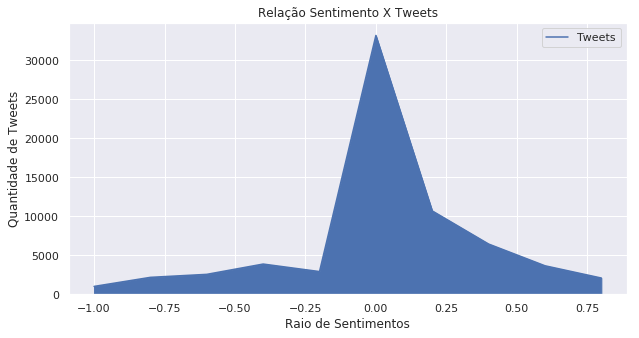

In [9]:
def createRangeDict(row):
    return {
        'user': row['user'],
        'sentiment': row['clean_sentiment']['Score']
    }

simplify_user_sentiment = pd.DataFrame([createRangeDict(x) for x in data])

data_simple_scores = simplify_user_sentiment.drop(columns=['user'])
sentiment_arrange = np.arange(-1, 1, 0.2)
sentiment_ind = np.digitize(
    data_simple_scores['sentiment'],
    sentiment_arrange
)


data_simple_scores = data_simple_scores.groupby(sentiment_ind).count()
data_simple_scores["range"] = pd.Series([x * 0.2 for x in range(-6, 6, 1)])

graph = data_simple_scores.plot(kind='area', x='range', y='sentiment', figsize=(10,5))
graph.set_xlabel('Raio de Sentimentos')
graph.set_ylabel('Quantidade de Tweets')
graph.set_title('Relação Sentimento X Tweets')
graph.legend(['Tweets'])


Partindo do principio que a partir de um score de -0.2 já existem menos dados, será tomada com premissa que qualquer dado com score superior a esse é um dado não viável para amostra. Seguindo essa premissa é precisso mapear de cada usúario o percentual de publicações a abaixo de -0.2, com isso será possível obter um percentual da densidade de publicações negativas naquele perfil.

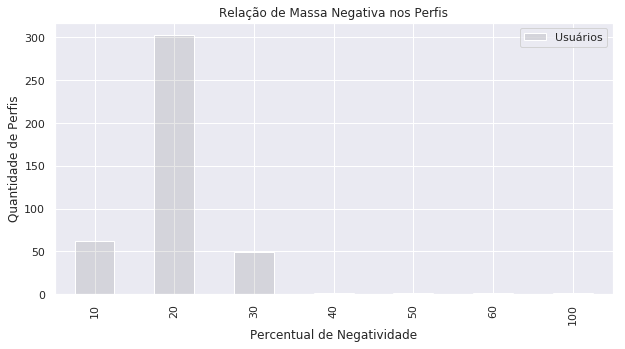

In [10]:
def map_percentual(item, *args, **kwargs):
    new_item = {
        'user': item[1]['user'],
        'negatives': [],
        'normals': [],
    }
    

    sentiment = item[1]['sentiment']
    new_item["negatives"] = len(sentiment[sentiment <= -0.2])
    new_item["normals"] = len(sentiment[sentiment > -0.2])

    total = new_item["normals"] + new_item["negatives"]

    new_item["npercentual"] = (new_item["negatives"] * 100) / total
    
    return new_item

data_negative_percentual = []
pre_data_negative_percentual = simplify_user_sentiment.groupby(by=['user'])

for item in pre_data_negative_percentual:  
    data_negative_percentual.append(map_percentual(item))
    
data_negative_percentual = pd.DataFrame(data_negative_percentual)

percentual_arrange = np.arange(0, 100, 10)
percentual_ind = np.digitize(
    data_negative_percentual['npercentual'],
    percentual_arrange
)

data_negative_percentual = data_negative_percentual.groupby(percentual_ind)

pre_graph2 = data_negative_percentual.count()
pre_graph2["range"] = pd.Series([x * 10 for x in range(0, 12, 1)])

graph2 = pre_graph2.plot(kind='bar', x='range', y='npercentual', color=(0.1, 0.1, 0.1, 0.1), figsize=(10, 5))
graph2.set_xlabel('Percentual de Negatividade')
graph2.set_ylabel('Quantidade de Perfis')
graph2.set_title('Relação de Massa Negativa nos Perfis')
graph2.legend(['Usuários'])

Analisando os dados do gráfico, é possível notar que a maior quantidade de percentual negativo esta entre 20% e 40%, entretanto, é impossível afirmar que os dados suprem as necessidades que a Inteligência Artificial ira necessitar para realizar a inferência na base. Refletindo sobre a EADS, a versão mitificada tem 21 perguntas, logo, necessita-se de no mínimo 21 tweets negativos na esperança que cada um responda pelo menos 1 das perguntas. Para validar a ideia é necessário descobrir a média de tweets dentro dos percentuais que mais contem massa negativa.

In [4]:
negatives_sum = data_negative_percentual[['negatives']].sum()
negatives_count = data_negative_percentual[['negatives']].count()

total_tweets = 0
total_users = 0

for _, value in negatives_sum.iteritems():
    for index in range(1,4):
        total_tweets = total_tweets + float(value[index])
        
for _, value in negatives_count.iteritems():
    for index in range(1,4):
        total_users = total_users + float(value[index])
    
print('Quantidade Tweets Negativos: {}'.format(total_tweets))
print('Quantidade de Usuarios Analisados: {}'.format(total_users))
print('Média de Tweets Negativos: {}'.format(total_tweets / total_users))

Quantidade Tweets Negativos: 9592.0
Quantidade de Usuarios Analisados: 413.0
Média de Tweets Negativos: 23.225181598062953


Uma vez obtido os dados do percentual e média de tweets é possível configurar o script para gerar amostra e tambem rodar um script para coletar dados resumidos para análise. Para que 

Quantidade Total de Usuários Encontrados: 21
Quantidade de Tweets Negativos: 907


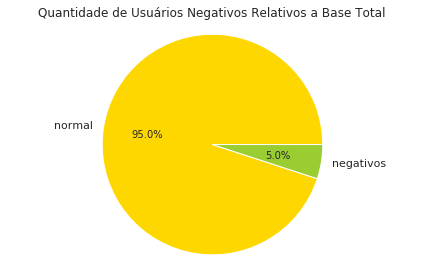

In [5]:
with open('/albert/data/sample-analytic-2018-10-15-21-05.json') as f:
    data2 = json.load(f)
    
total_tweets_negativos = 0
for sample in data2:
    total_tweets_negativos += len(sample["NegativeTweets"])

graph_session_labels = ['normal', 'negativos']
graph_session_colors = ['gold', 'yellowgreen']
graph3 = [len(data_grouped_by_user) - len(data2), len(data2)]
graph4 = [len(data) - total_tweets_negativos, total_tweets_negativos]

print('Quantidade Total de Usuários Encontrados: {}'.format(len(data2)))
print('Quantidade de Tweets Negativos: {}'.format(total_tweets_negativos))

matplotlib.pyplot.pie(graph3, labels=graph_session_labels, autopct='%1.1f%%', colors=graph_session_colors)
matplotlib.pyplot.axis('equal')
matplotlib.pyplot.title('Quantidade de Usuários Negativos Relativos a Base Total')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()



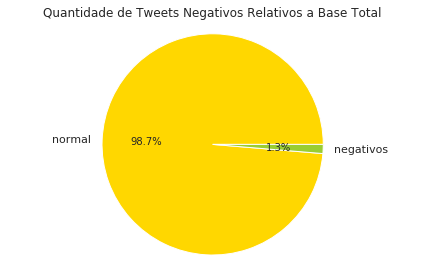

In [6]:
matplotlib.pyplot.pie(graph4, labels=graph_session_labels, autopct='%1.1f%%', colors=graph_session_colors)
matplotlib.pyplot.axis('equal')
matplotlib.pyplot.title('Quantidade de Tweets Negativos Relativos a Base Total')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

SyntaxError: invalid syntax (<ipython-input-7-c1c5fb8e2a18>, line 14)